# Board Games

Author: Alicia Chuang

Student ID: 37703653

Course Project, UC Irvine, Math 10, W22

## Introduction


The goal of this project is to explore the correlation between different aspects of board games using regression and neural networks. Aspects explored include year of publication and number of user ratings and the effects of different factors on the board game rating. 

## Main portion of the project


**_Importing libraries_**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

import torch
from torch import nn
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_error

from statistics import mean

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**_Loading file_**

In [2]:
df = pd.read_csv("/work/bgg_dataset-20220302-203730.csv/bgg_dataset.csv", delimiter=';')
df.dropna(inplace=True)

**_Display format of dataframe_**

In [3]:
df.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


**_Section 1_**

**_Goal: Check correlation between users owned, users rated, and year published_**

Data Used: Rows that contain years 2010-2022 and owned users between 5000 and 40000

Method: K nearest neighbors regressor and linear regression

In [4]:
df2 = df[(df['Year Published'].isin(range(2010, 2023))) & (df['Owned Users'].isin(range(5000, 40001)))]

**_Splitting and fitting data_**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df2[['Owned Users']], df2['Users Rated'], test_size = 0.2)
reg = KNeighborsRegressor(n_neighbors=7)
pred = reg.fit(X_train, y_train)

**_Plot K Nearest Neighbors Regression_**

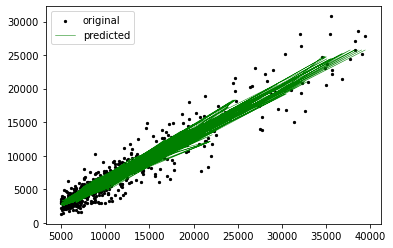

In [6]:
plt.scatter(X_train, y_train, s=5, color="black", label="original")
plt.plot(X_train, reg.predict(X_train), lw=0.5, color="green", label="predicted")
plt.legend()
plt.show()

In [7]:
mean_absolute_error(reg.predict(X_test), y_test)

1469.2868303571427

In [8]:
mean_absolute_error(reg.predict(X_train), y_train)

1185.6323323042377

**_Error Analysis_**

The mean aboslute error for the training data and the test data are relatively close, so there is no sign of overfitting of the data. While the absolute errors may seem large, because of the large step sizes, the relative errors are acceptable.

In [9]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"The slope of the linear regression is {reg.coef_[0]}")

The slope of the linear regression is 0.707883245086142


**_Plot Linear Regression_**

In [10]:
alt.Chart(df2).mark_point(opacity=0.7).encode(
    x = alt.X("Owned Users",scale = alt.Scale(zero=False)),
    y = alt.Y("Users Rated", scale = alt.Scale(zero=False)),
    color = "Year Published"
).properties(
    title = "Owned Users vs Users Rated"
).interactive()

alt.Chart(...)

**_Analysis_**

The number of owned users is positively correlated with the number of users rated by a factor of 0.69. As the number of people who own the game increases, the number of people who rate the game also increases, and as a general trend, if the game is published earlier, the percentage of the people who rate the game is higher than for the games published later.

**_Section 2_**

**_Goal: Predict the rating of a game based on the features of the game_**

Data Used: The original dataframe with rows containing na values dropped

Method: Neural networks

**_Converting data types_**

In [11]:
df['Rating Average'] = df['Rating Average'].apply(lambda x: np.char.replace(x, ',', '.'))
df['Complexity Average'] = df['Complexity Average'].apply(lambda x: np.char.replace(x, ',', '.'))
df['Rating Average'] = pd.to_numeric(df['Rating Average']).astype(int)
df['Complexity Average'] = pd.to_numeric(df['Complexity Average'])

**_Reformating data for input_**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df[['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age', 'Complexity Average']], df['Rating Average'], test_size = 0.2)
X_train = [[list(X_train['Year Published'])[i], list(X_train['Min Players'])[i], list(X_train['Max Players'])[i], list(X_train['Play Time'])[i], list(X_train['Min Age'])[i],list(X_train['Complexity Average'])[i]] for i in range(len(X_train))]
X_test = [[list(X_test['Year Published'])[i], list(X_test['Min Players'])[i], list(X_test['Max Players'])[i], list(X_test['Play Time'])[i], list(X_test['Min Age'])[i],list(X_test['Complexity Average'])[i]] for i in range(len(X_test))]

**_Creating neural network_**

In [13]:
class Boardgames(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(6,5),
            nn.Sigmoid(),
            nn.Linear(5,3),
            nn.ReLU(),
            nn.Linear(3,10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self,x):
        x = x
        z = self.layers(x)
        return z

In [14]:
obj = Boardgames()

**_Training neural network_**

In [15]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(obj.parameters(), lr=4)
epochs = 10

for i in range(epochs):
    y_true = torch.tensor(list(y_train)) - 1
    y_pred = obj(torch.tensor(X_train))
    loss = loss_fn(y_pred, y_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Training loss:")
    print(loss)

    y_pred = obj(torch.tensor(X_test))
    y_true = torch.tensor(list(y_test)) - 1
    loss = loss_fn(y_pred, y_true)
    print("Test loss:")
    print(loss)
    print('\n')

Training loss:
tensor(2.2025, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.5589, grad_fn=<NllLossBackward0>)


Training loss:
tensor(1.5504, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.7944, grad_fn=<NllLossBackward0>)


Training loss:
tensor(1.8064, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.6090, grad_fn=<NllLossBackward0>)


Training loss:
tensor(1.5947, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.4651, grad_fn=<NllLossBackward0>)


Training loss:
tensor(1.4591, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.4147, grad_fn=<NllLossBackward0>)


Training loss:
tensor(1.4118, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.3923, grad_fn=<NllLossBackward0>)


Training loss:
tensor(1.3902, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.3788, grad_fn=<NllLossBackward0>)


Training loss:
tensor(1.3771, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.3697, grad_fn=<NllLossBackward0>)


Training loss:
tensor(1.3682, grad_fn=<NllLossBackward0>)
Test loss:
tensor(1.3630, grad

**_Analysis_**

The loss for the training data and the test data are both decreasing, so the neural network is working, and the training and test losses are very close, so there is no sign of overfitting.

**_Section 3_**

**_Goal: Visualize the data to put things into context_**

Data Used: Year published (1600-2022) and owned users

In [16]:
df3 = df[df['Year Published'].isin(range(1600, 2023))][['Year Published', 'Owned Users']]
df3['Year Published'] = df3['Year Published'] // 100
df3.head()

,Year Published,Owned Users
0,20.0,68323.0
1,20.0,65294.0
2,20.0,28785.0
3,20.0,87099.0
4,20.0,16831.0


In [17]:
pub_vals = {}
size = 0
for i in set(df3['Year Published']):
    pub_vals[i] = sum(df3['Year Published'] == i)
    size += pub_vals[i]
pub_vals

{16.0: 6, 17.0: 11, 18.0: 27, 19.0: 2835, 20.0: 6753}

In [18]:
avg_vals = {}
for i in set(df3['Year Published']):
    avg_vals[i*100] = mean(df3[df3['Year Published']==i]['Owned Users'])
avg_vals

{1600.0: 2701.5,
 1700.0: 684.8181818181819,
 1800.0: 2881.5925925925926,
 1900.0: 1349.7961199294532,
 2000.0: 3105.626388271879}

**_Plot Bar Chart_**

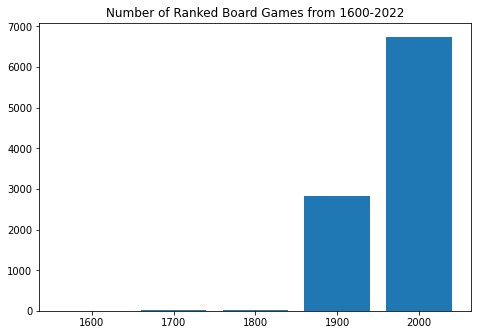

In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = []
sizes = []
for key, val in pub_vals.items():
    labels.append(key*100)
    sizes.append(val)
ax.bar(labels,sizes, 80)
plt.title("Number of Ranked Board Games from 1600-2022")
plt.show()

**_Plot Pie Chart_**

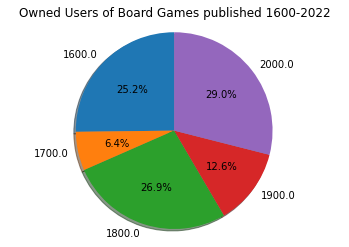

In [20]:
labels = []
sizes = []
for key, val in avg_vals.items():
    labels.append(key)
    sizes.append(val/size)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal') 
plt.title("Owned Users of Board Games published 1600-2022")

plt.show()

**_Analysis_**

Although there has only been 22 years in the 2000s so far, the number of boardgames published outnumber any of the other centuries by a significant amount. However, the average number of users for board games published in different years number roughly the same with 1700 being about 1/4 of the other centuries and 1900 about 1/2.


## Summary

The project is split into 3 sections. The first analyzes the correlation between users owned, users rated, and the year published using regression. The second is a neural network that predicts the rating of a board game given six aspects of the game. The third gives a visualization of the dataset in terms of boardgames published and users owned in each century.

## References

Import statements: https://christopherdavisuci.github.io/UCI-Math-10-W22/Week7/Week7-Monday.html

Dataset: https://www.kaggle.com/andrewmvd/board-games

Convert string to ints: https://stackoverflow.com/questions/21291259/convert-floats-to-ints-in-pandas

Plotting K nearest neighbors: https://www.datatechnotes.com/2019/04/regression-example-with-k-nearest.html

Customizing altair charts: https://altair-viz.github.io/user_guide/customization.html

Matplotlib bar chart: https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

Matplotlib pie chart: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html

Mean function: https://www.geeksforgeeks.org/python-statistics-mean-function/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5a3c711c-de92-4ae4-b61d-d6a8182ff089' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>